In [20]:
import tensorflow as tf
import numpy as np
from object_detection.metrics.coco_evaluation import CocoDetectionEvaluator
from object_detection.core import standard_fields as fields
import pandas as pd
from object_detection.utils import config_util
from object_detection.builders import model_builder
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import pickle

from detection_utils import tfrecord_2_groundtruth_info, detections_2_detection_info, load_model, inference_from_bytes


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set_theme()

import os
os.chdir('/Users/jilliana/Documents/rcg_projects/RuthJoy/Cormorants')

In [10]:
# Create the Evaluator
evaluator = CocoDetectionEvaluator(categories = [
                                                 {'id': 1, 'name': 'Cormorant'},
                                                 {'id': 2, 'name': 'Nest'},
                                                 ])

# Adding Groundtruth Data
TFRECORD_FILE = [
                 'cormorants-nesting-scripts/object_detection_scripts/lost_to_tf/output/snb2/validation.tfrecord', 
                 'cormorants-nesting-scripts/object_detection_scripts/lost_to_tf/output/snb1/validation.tfrecord',
                 'cormorants-nesting-scripts/object_detection_scripts/lost_to_tf/output/snb3/validation.tfrecord'
                 ]

ground_truth, raw_images_to_predict = tfrecord_2_groundtruth_info(TFRECORD_FILE)

# ****************
# Do Predictions
# ****************
# EXPORTED_MODEL_DIR = Path('cormorants-nesting-scripts/object_detection_scripts/predict/input/models/snb1_centernet_resnet101_512_v3')
# EXPORTED_MODEL_DIR = Path('cormorants-nesting-scripts/object_detection_scripts/predict/input/models/snb2_centernet_resnet101_512_v1')
EXPORTED_MODEL_DIR = Path('cormorants-nesting-scripts/object_detection_scripts/predict/input/models/snb3_centernet_resnet101_512_v1')
CONFIDENCE_SCORES = list(np.linspace(0,1,20,endpoint=False))

# detection_model, checkpoint = load_model(EXPORTED_MODEL_DIR)

# all_detections = []
# for score in CONFIDENCE_SCORES:
#     detections = inference_from_bytes(raw_images_to_predict,
#                                       detection_model,
#                                       box_th=score)
#     all_detections.append((score, detections))

# ****************
# Record mAPs
# ****************    
# all_mAPs = []
# for score, detections in all_detections:
#     print(f"*** {score} ***")
#     evaluator.clear()
#     for img_id, gt_dict in ground_truth:
#         evaluator.add_single_ground_truth_image_info(img_id, gt_dict)
    
#     detection_info = detections_2_detection_info(detections)
#     for img_id, d_dict in detection_info:
#         if len(d_dict['detection_boxes'] != 0):
#             results = evaluator.add_single_detected_image_info(img_id, d_dict)
#     results = evaluator.evaluate()
#     all_mAPs.append((score, results))

In [11]:
# ***********
# Write mAPs
# ***********
# with open("snb2_123_cor.pkl", 'wb') as file:
#     pickle.dump(all_mAPs, file)

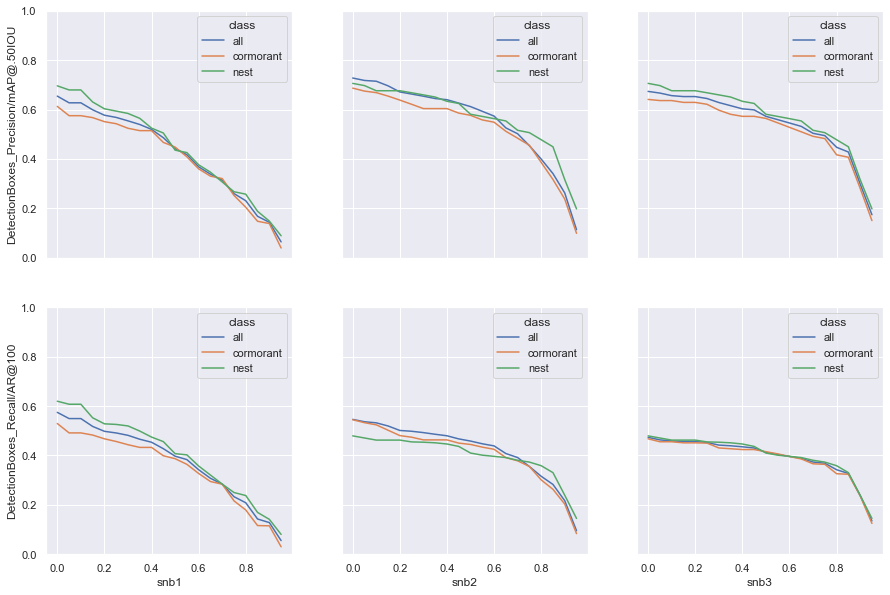

In [84]:
# **********
# ALL PLOTS
# **********
model_results = {'snb1': {'all': 'snb1_123.pkl', 
                          'cormorant': 'snb1_123_cor.pkl', 
                          'nest': 'snb1_123_nes.pkl'}, 
                 'snb2': {'all': 'snb2_123.pkl', 
                          'cormorant': 'snb2_123_cor.pkl', 
                          'nest': 'snb2_123_nes.pkl'}, 
                 'snb3': {'all': 'snb3_123.pkl', 
                          'cormorant': 'snb3_123_cor.pkl', 
                          'nest': 'snb3_123_nes.pkl'}
                 }
dfs = []
for model in model_results:
    for clss, f in model_results[model].items():
        with open(f, 'rb') as file:
            mAPs = pickle.load(file)
        df = pd.DataFrame(m[1] for m in mAPs)
        df['confidence_score'] = CONFIDENCE_SCORES
        df['model'] = model
        df['class'] = clss
        dfs.append(df)
            
df = pd.concat(dfs).reset_index()

# Plotting
VALUES_TO_PLOT = ['DetectionBoxes_Precision/mAP@.50IOU', 'DetectionBoxes_Recall/AR@100']
fig, axs = plt.subplots(figsize=(15,10), ncols=3, nrows=len(VALUES_TO_PLOT), sharex=True, sharey=True)

for col_idx, model in enumerate(df['model'].unique()):
    data = df[df['model'] == model]
                        
    for row_idx, value in enumerate(VALUES_TO_PLOT):
        l = sns.lineplot(data=data, 
                         x='confidence_score', 
                         y=value, 
                         hue='class', 
                         ax=axs[row_idx][col_idx]
                        )
        l.set(ylim=(0, 1))
        l.set(ylabel=value)
        l.set(xlabel=model)